<h1 align="center">Volume 4: Inverse Problems.</h1>

    Bryant McArthur
    Math 439
    March 9, 2023

In [54]:
import numpy as np
from scipy.optimize import root
from scipy.integrate import solve_ivp
from matplotlib import pyplot as plt
from scipy import linalg as la

# Problem 1

Write a function that returns the matrices A, B, Q, and R given above. Let
g = 9.8 m/s
2
.

In [2]:
def linearized_init(M, m, l, q1, q2, q3, q4, r):
    '''
    Parameters:
    ----------
    M, m: floats
          masses of the rickshaw and the present
    l   : float
          length of the rod
    q1, q2, q3, q4, r : floats
        relative weights of the position and velocity of the rickshaw, the
        angular displacement theta and the change in theta, and the control


    Return
    -------
    Q : ndarray of shape (4,4)
    R : ndarray of shape (1,1)
    '''
    g = 9.8
    
    A = np.array([[0,1,0,0],
                 [0,0,m*g/M,0],
                 [0,0,0,1],
                 [0,0,g/(M*l)*(M+m),0]])
    
    B = np.array([[0],[1/M],[0],[1/(M*l)]])
    Q = np.diag([q1,q2,q3,q4])
    R = np.array([[r]])
    
    return A,B,Q,R

# Problem 2

Write the following function to find the matrix $P$ using `scipy.optimize.root`.
Since root takes in a vector and not a matrix, you will have to reshape the matrix P before
passing it in and after getting your result, using `np.reshape(16)` and `np.reshape((4,4))`.

In [42]:
def find_P(A,B,Q,R):
    '''
    Parameters:
    ----------
    A, Q : ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    
    Returns
    -------
    P : the matrix solution of the Riccati equation
    '''
    def f(p):
        p = p.reshape((4,4))
        
        P = p@A + A.T@p + Q - p@B@np.linalg.inv(R)@B.T@p
        
        return P.reshape(16)
    
    P0 = np.ones((4,4))
    P = root(f,P0).x
    
    return P.reshape((4,4))

In [43]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.

A,B,Q,R = linearized_init(M,m,l,q1,q2,q3,q4,r)
P = find_P(A,B,Q,R)

eigs,eigvecs = np.linalg.eig(A-B@np.linalg.inv(R)@B.T@P)
print(eigs)
print(np.any(eigs>0))

[-1.72875212+0.j         -0.07538846+0.07490226j -0.07538846-0.07490226j
  1.72530814+0.j        ]
True


Yes at least one of the eigenvalues is positive. Z does not necessarily go to 0.

# Problem 3
 
Write the following function that implements the LQR solution described earlier.
Use `scipy.integrate.solve_ivp` to solve the IVP.

In [132]:
def rickshaw(tv, X0, A, B, Q, R, P):
    '''
    Parameters:
    ----------
    tv : ndarray of time values, with shape (n+1,)
    X0 : Initial conditions on state variables
    A, Q: ndarrays of shape (4,4)
    B : ndarray of shape (4,1)
    R : ndarray of shape (1,1)
    P : ndarray of shape (4,4)
    Returns
    -------
    Z : ndarray of shape (n+1,4), the state vector at each time
    U : ndarray of shape (n+1,), the control values
    '''
    
    def ode(t,z):
        """Define ODE System"""
        return (A-B@np.linalg.inv(R)@B.T@P)@z

    # solve system
    sol = solve_ivp(ode, (tv[0],tv[-1]), X0, t_eval=tv)

    U = -np.linalg.inv(R)@B.T@P@sol.y
    
    return sol.y, U.flatten(), sol.t

# Problem 4

Test the function made in Problem (3). Find the matrix $P$ using the `scipy.optimize.root` method and plot with `tf=6` as well as the `solve_continuous_are`
method and plot with `tf=60`. Plot the solutions $\tilde{z}$ and $\tilde{u}$. Compare your results to Figure
21.3.

In [137]:
M, m = 23., 5.
l = 4.
q1, q2, q3, q4 = 1., 1., 1., 1.
r = 10.
tf = 6
X0 = np.array([-1, -1, .1, -.2])

tv = np.linspace(0,tf,200)

P = find_P(A,B,Q,R)

Z,U,t = rickshaw(tv,X0,A,B,Q,R,P)

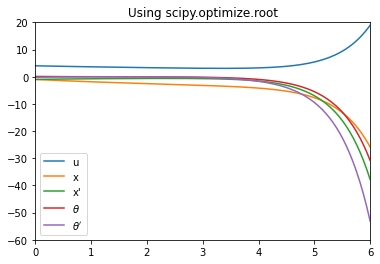

In [138]:
plt.plot(t,U, label='u')
plt.plot(t,Z[0], label='x')
plt.plot(t,Z[1], label="x'")
plt.plot(t,Z[2], label=r"$\theta$")
plt.plot(t,Z[3], label=r"$\theta'$")
plt.title("Using scipy.optimize.root")
plt.xlim(0,6)
plt.ylim(-60,20)
plt.legend()
plt.show()

In [135]:
P = la.solve_continuous_are(A,B,Q,R)
tf = 60
tv = np.linspace(0,tf,100)

Z,U,t = rickshaw(tv,X0,A,B,Q,R,P)

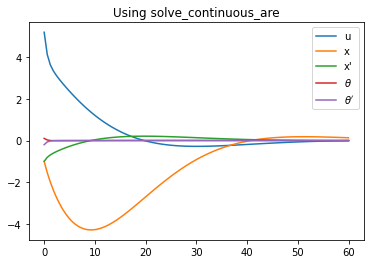

In [136]:
plt.plot(t,U, label='u')
plt.plot(t,Z[0], label='x')
plt.plot(t,Z[1], label="x'")
plt.plot(t,Z[2], label=r"$\theta$")
plt.plot(t,Z[3], label=r"$\theta'$")
plt.title("Using solve_continuous_are")
plt.legend()
plt.show()